In [1]:
#import libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings 

warnings.filterwarnings("ignore") # Disable deprecation warnings 

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear.

In [2]:
#import dataframe
path = r'C:\Users\nrsmi\OneDrive\Documents\CareerFoundry\09-2024 Advanced Analytics & Dashboard\Python\10-2024 Analyzing Global Temperature Changes'
df = pd.read_csv(os.path.join(path, '02_Data', 'Prepared Data', 'df_TC_climate_region_CLEAN.csv'), index_col = False)

In [3]:
df.head()

,Country,Months,Element,Year,Temperature,Region,Climate
0,Afghanistan,January,Temperature Change,1961,0.777,Asia,Continental
1,Afghanistan,February,Temperature Change,1961,-1.743,Asia,Continental
2,Afghanistan,March,Temperature Change,1961,0.516,Asia,Continental
3,Afghanistan,April,Temperature Change,1961,-1.709,Asia,Continental
4,Afghanistan,May,Temperature Change,1961,1.412,Asia,Continental


# 3. Make a subset of your data set if necessary. Think about the historical domain of the series to decide if you need to (if there are irrelevant historical events in your data that would bias your analysis, for example). Also, make sure your set doesn’t include any forecasted data.e.

In [5]:
# Combining Year and Month into a datetime format
df_sub = df.copy()
df_sub['Date'] = pd.to_datetime(df_sub['Year'].astype(str) + '-' + df_sub['Months'] + '-01', errors='coerce')

In [6]:
df_sub.head()

,Country,Months,Element,Year,Temperature,Region,Climate,Date
0,Afghanistan,January,Temperature Change,1961,0.777,Asia,Continental,1961-01-01
1,Afghanistan,February,Temperature Change,1961,-1.743,Asia,Continental,1961-02-01
2,Afghanistan,March,Temperature Change,1961,0.516,Asia,Continental,1961-03-01
3,Afghanistan,April,Temperature Change,1961,-1.709,Asia,Continental,1961-04-01
4,Afghanistan,May,Temperature Change,1961,1.412,Asia,Continental,1961-05-01


In [7]:
df_sub.shape

(180540, 8)

In [8]:
# Drop rows with NaN values in 'Date' and 'Temperature'
df_sub = df_sub.dropna(subset=['Date', 'Temperature'])

In [9]:
df_sub.shape

(159632, 8)

In [10]:
#aggregate temperature for each country for each year
df_sub = df_sub.groupby(['Date'], as_index=False)['Temperature'].mean()

In [11]:
df_sub.head()

,Date,Temperature
0,1961-01-01,0.105301
1,1961-02-01,0.244685
2,1961-03-01,0.263616
3,1961-04-01,0.418144
4,1961-05-01,0.225565


In [12]:
df_sub.to_csv(os.path.join(path, '02_Data','Prepared Data', 'df_TC_AvgTempByDate.csv'))

## In a markdown cell below the subset (if you make one), explain what logic you were following when selecting your data points.

- I filtered for non-null values and created a date column to be able to aggregate by year and month

## Remember that if you subset your data, you’ll need to reset the index, subset, then reset the “Date” column as your index in the new dataframe.

In [16]:
#set date as index
df_sub.set_index('Date', inplace=True)

In [17]:
df_sub.head()

,Temperature
Date,
1961-01-01,0.105301
1961-02-01,0.244685
1961-03-01,0.263616
1961-04-01,0.418144
1961-05-01,0.225565


# 4. Create a line chart of your data

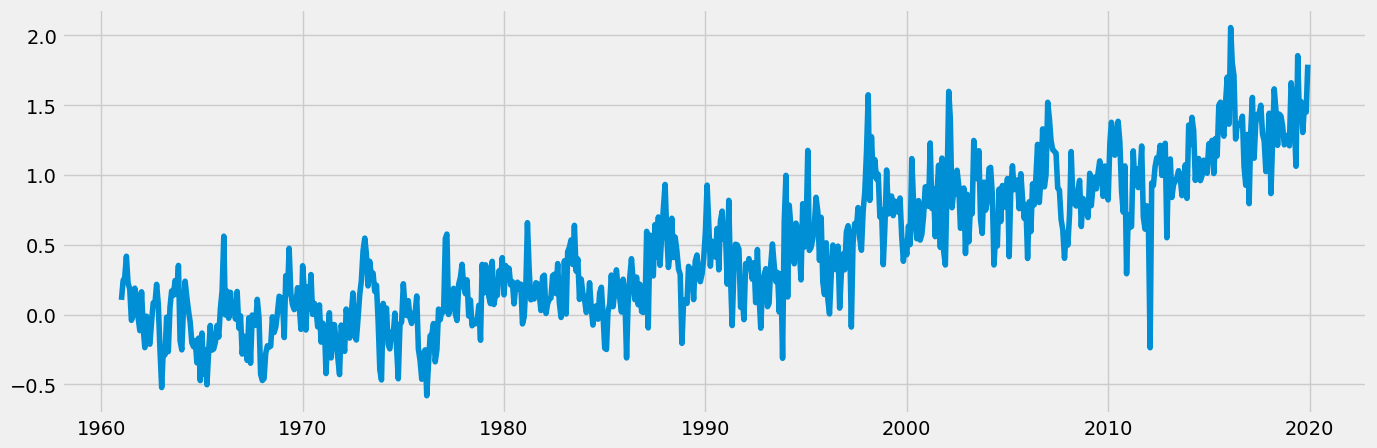

In [19]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

In [20]:
# Check for missing values 
df_sub.isnull().sum() 

Temperature    0
dtype: int64

In [21]:
# Check for duplicates
dups = df_sub.duplicated()
dups.sum()

0

# 5. Decompose the data’s components..

In [23]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive')

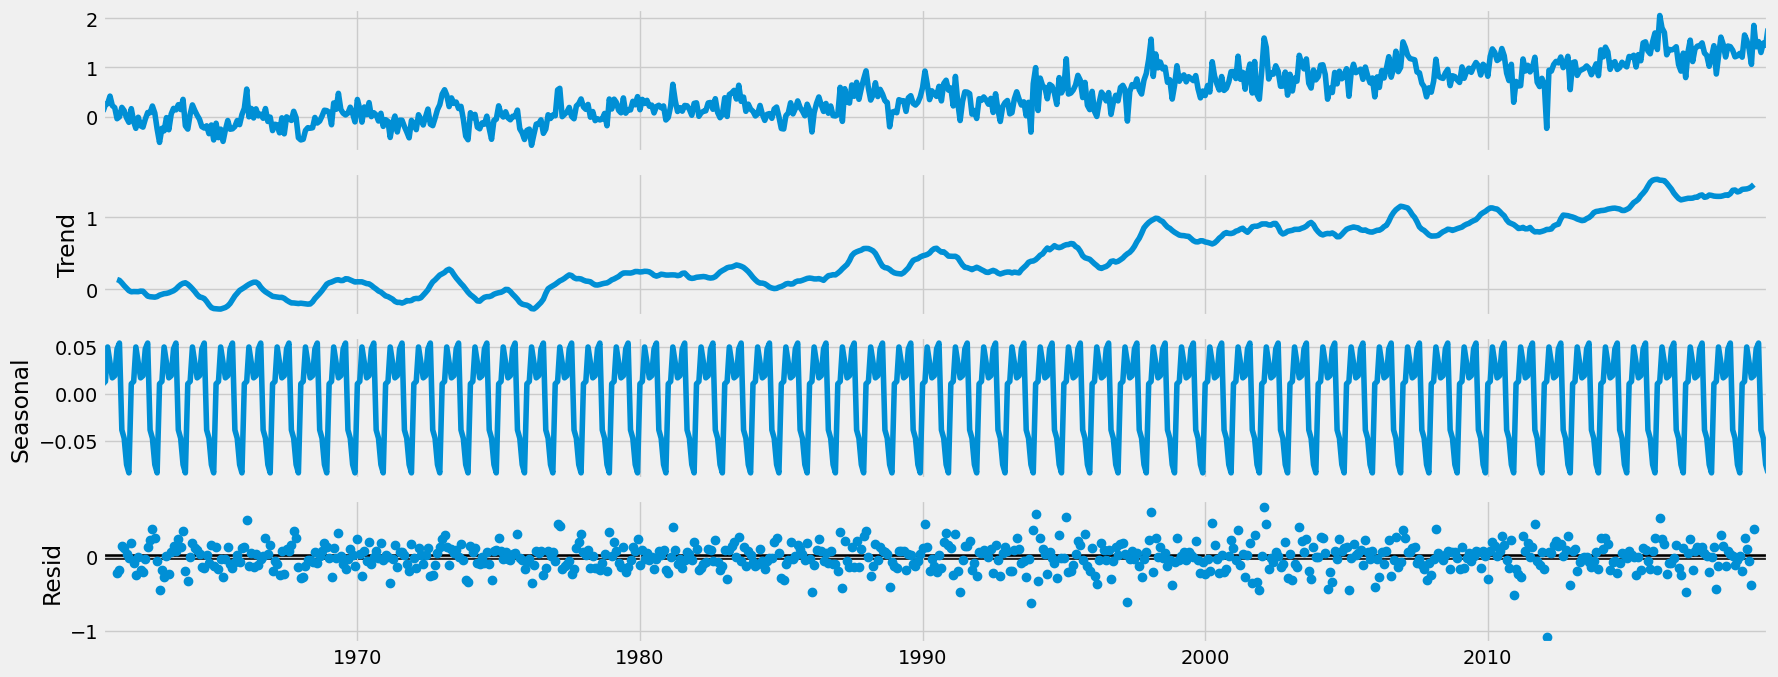

In [24]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

# Plot the separate components

decomposition.plot()
plt.show()

## Analyze the results from the plot in a markdown cell.

- this decomposition reveals a long-term increasing trend, clear seasonal cycles, and minimal random noise, which suggests that the data is well-structured with strong trend and seasonal components.

# 6. Conduct a Dickey-Fuller test to check for stationarity.

In [28]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Temperature'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.993492
p-value                          0.755631
Number of Lags Used             12.000000
Number of Observations Used    695.000000
Critical Value (1%)             -3.439794
Critical Value (5%)             -2.865708
Critical Value (10%)            -2.568989
dtype: float64


### Interpret the results in a markdown cell and reference your null hypothesis.

- Test Statistic: The value of -0.993 is higher than the critical values, so it doesn’t meet the threshold to be considered stationary.
- p-value: The p-value of 0.756 is quite large, meaning there isn’t enough evidence to say the data is stationary.

# 7. If your data still isn’t stationary, perform another round of differencing and repeat step 6.

In [32]:
df_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [33]:
df_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [34]:
df_diff.head()

,Temperature
Date,
1961-02-01,0.139384
1961-03-01,0.018931
1961-04-01,0.154528
1961-05-01,-0.192579
1961-06-01,-0.041764


In [35]:
df_diff.columns

Index(['Temperature'], dtype='object')

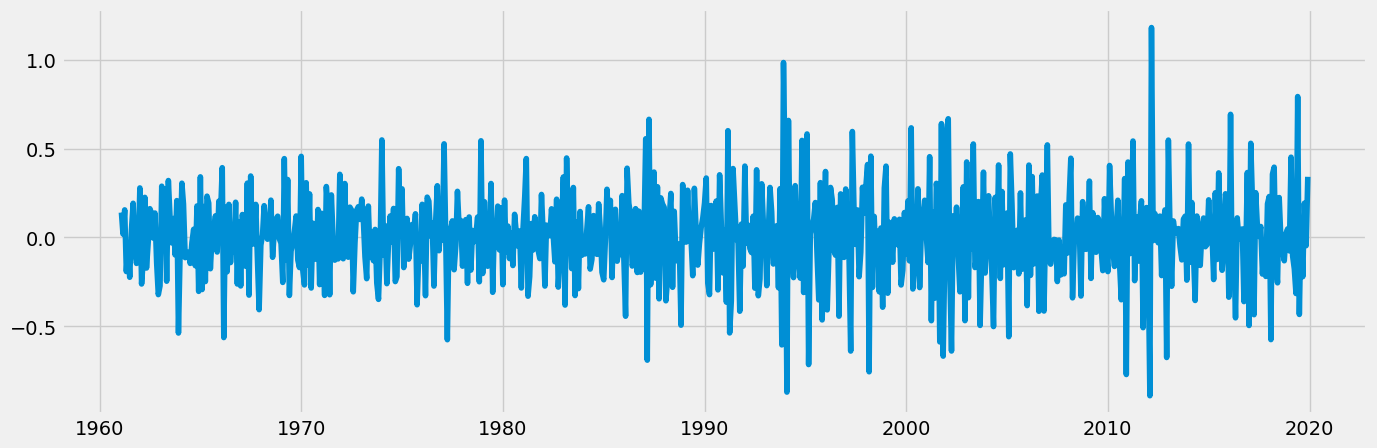

In [36]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [37]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.126436e+01
p-value                        1.593046e-20
Number of Lags Used            1.100000e+01
Number of Observations Used    6.950000e+02
Critical Value (1%)           -3.439794e+00
Critical Value (5%)           -2.865708e+00
Critical Value (10%)          -2.568989e+00
dtype: float64


- Since the test statistic is much lower than the critical values and the p-value is very low, we conclude that the differenced data is stationary

# 9. Check your data’s autocorrelations.

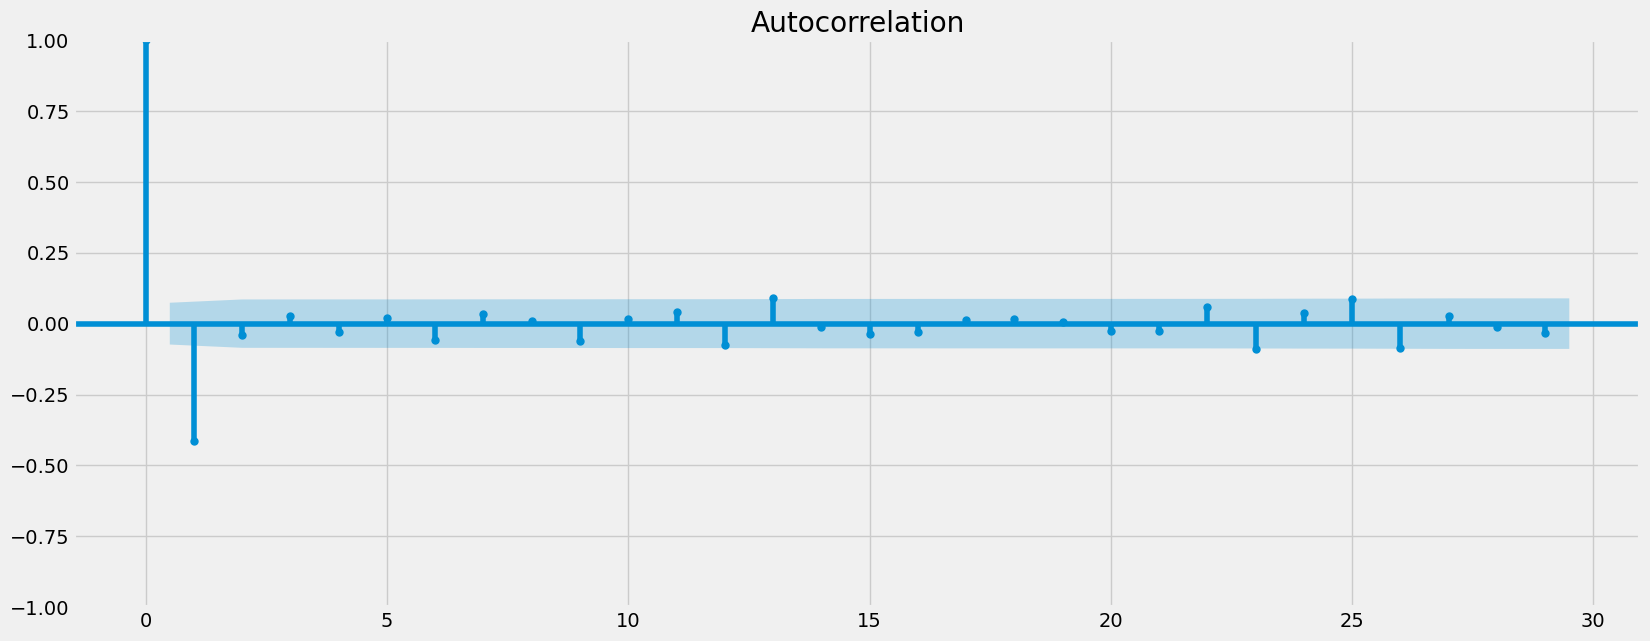

In [40]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_diff)
plt.show()